In [1]:
from custgeneratorv2 import customerMaker, customerFeeder
from sumplotter import plot_arm_loss, plot_c_regret, plot_c_reward
from modelbuilderv2 import ringDealer
import tensorflow as tf
import numpy as np
from tqdm import tqdm

In [12]:
tf.reset_default_graph() 
#to calc cumulative reward
c_reward = {'wtp':[], 'model':[], 'one': [],
            'two': [], 'three':[], 'four':[], 'five':[]}

#dictionary of lists to store losses by arm
losses = {1:[],2:[],3:[],4:[],5:[]}

#monitor whether policy for new vs return cust
c_type = []

logs_path = "tensorboard/temporal_price_board_1"
purchases = 62000
n_purchases = 5
#inititalize neural nets

params = {'lr': .000074, 'n_hidden_lstm': 16, 'n_cell_lstm': 2, 'out_lstm': 5, 'n_hidden_affine': 32, 'n_cell_affine': 2}
rd = ringDealer(**params)
#initialize the customer cache
cFeed = customerFeeder(maxsize=n_purchases)
cFeed.forecastNewCust(purchases) #forecast when new customers come in
e = 0.1

init = tf.initialize_all_variables()
# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    #writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())
    writer = tf.summary.FileWriter(logs_path, sess.graph)
    for i in tqdm(range(purchases)):
        if i in cFeed.newbies:
            #document customer type
            c_type.append('n') #new
            
            #new customer purchase
            cFeed.getNewCust()
            #feed blank history
            purchases = np.zeros((1, n_purchases))
        else:
            #document customer type
            c_type.append('r') #return
            
            #old customer purchase
            cFeed.getOldCust()
            
            #left pad purchase history
            p_len = len(cFeed.history)
            pad = n_purchases - p_len
            purchases = np.concatenate((np.zeros((1,pad)), \
                                        np.reshape(cFeed.history,\
                                        (1,p_len))), axis=1)
        #pull out the context and wtp before action
        species_num, magic_num, power_num, status_num  = cFeed.context
        wtp = cFeed.wtp
        
        purchase_num = np.reshape(purchases, [1, -1, n_purchases])
        
        feed_dict={rd.species_in:[species_num],
                   rd.magic_in:[magic_num],
                   rd.power_in:[power_num],
                   rd.status_in:[status_num],
                   rd.purchase_in: purchase_num}
        
        if np.random.rand(1) < e: #explore!
            #choose a random action (from 0-1 for now)
            action = np.random.randint(1,6) #because we never find it favorable to choose 0 
            exploit = False #remember we explore
        else:
            action = int(sess.run(rd.best_action,feed_dict=feed_dict))
            exploit = True
        
        if i in cFeed.newbies:
            deal = cFeed.feedNewCust(action=action) #new cust
            
            baseline_deals = []
            #baselines 
            baseline_deals.append(cFeed.feedNewCust(action=1, cachename='one'))
            baseline_deals.append(cFeed.feedNewCust(action=2, cachename='two'))
            baseline_deals.append(cFeed.feedNewCust(action=3, cachename='three'))
            baseline_deals.append(cFeed.feedNewCust(action=4, cachename='four'))
            baseline_deals.append(cFeed.feedNewCust(action=5, cachename='five'))
        else:
            deal = cFeed.feedOldCust(action=action) #old cust
            #get the baseline for every possible action
            baseline_deals = []
            cFeed.getOldCust('one')
            baseline_deals.append(cFeed.feedOldCust(action=1, cachename='one'))
            cFeed.getOldCust('two')
            baseline_deals.append(cFeed.feedOldCust(action=2, cachename='two'))
            cFeed.getOldCust('three')
            baseline_deals.append(cFeed.feedOldCust(action=3, cachename='three'))
            cFeed.getOldCust('four')
            baseline_deals.append(cFeed.feedOldCust(action=4, cachename='four'))
            cFeed.getOldCust('five')
            baseline_deals.append(cFeed.feedOldCust(action=5, cachename='five'))
        
        feed_dict[rd.reward_holder] = [deal]
        feed_dict[rd.action_holder] = [int(action)]
        
        _, ls, p, a2 = sess.run([rd.update, rd.loss, rd.chosen_prob, rd.probs], feed_dict=feed_dict)

        #writer.add_summary(ls, global_step=i)
        #store rewards
        c_reward['wtp'].append(wtp)
        c_reward['model'].append(action * deal)
        c_reward['one'].append(1 * baseline_deals[0])
        c_reward['two'].append(2 * baseline_deals[1])
        c_reward['three'].append(3 * baseline_deals[2])
        c_reward['four'].append(4 * baseline_deals[3])
        c_reward['five'].append(5 * baseline_deals[4])
        
        #if loss belongs to arm, append it
        if action is not 0:
            losses[action].append(ls)
    
        if i % 599 is 0:
            
            print('\n----------------')
            if i in cFeed.newbies:
                print('NEW')
            else:
                print('RETURN')
            if exploit:
                print("EXPLOIT")
            else:
                print("EXPLORE")
            #print("context is: {}".format(context))
            print("wtp is {}, chose {}".format(wtp, action)) #hard coded for now
            print("probablity of  accept is {}".format(float(p)))
            print("probablity of 2 is {}".format(a2))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 7/62000 [00:00<7:07:37,  2.42it/s] 


----------------
NEW
EXPLOIT
wtp is 3, chose 5
probablity of  accept is 0.471615195274353
probablity of 2 is [ 0.48646453  0.41782194  0.53044188  0.56950426  0.41932347  0.4716152 ]


  1%|          | 604/62000 [00:12<19:03, 53.68it/s] 


----------------
RETURN
EXPLOIT
wtp is 0, chose 5
probablity of  accept is 0.42892494797706604
probablity of 2 is [ 0.45943764  0.42076975  0.43676072  0.49571651  0.42084646  0.42892495]


  2%|▏         | 1209/62000 [00:24<17:40, 57.33it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 5
probablity of  accept is 0.36069363355636597
probablity of 2 is [ 0.4242146   0.42042756  0.50963944  0.51508719  0.29534587  0.36069363]


  3%|▎         | 1803/62000 [00:36<19:35, 51.23it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 5
probablity of  accept is 0.3906012177467346
probablity of 2 is [ 0.49220753  0.39545208  0.39233541  0.45596099  0.2701095   0.39060122]


  4%|▍         | 2404/62000 [00:49<19:54, 49.88it/s]


----------------
RETURN
EXPLORE
wtp is 0, chose 2
probablity of  accept is 0.5137015581130981
probablity of 2 is [ 0.47883025  0.33267921  0.51370156  0.33460242  0.25885367  0.20750657]


  5%|▍         | 3001/62000 [01:01<27:04, 36.32it/s]


----------------
NEW
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.43068727850914
probablity of 2 is [ 0.47625375  0.42765716  0.39154583  0.45399395  0.31280538  0.43068728]


  6%|▌         | 3601/62000 [01:16<23:52, 40.76it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.6745720505714417
probablity of 2 is [ 0.54853189  0.42777881  0.27931452  0.3483938   0.1949385   0.67457205]


  7%|▋         | 4205/62000 [01:26<16:10, 59.56it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.8876659870147705
probablity of 2 is [ 0.504008    0.4049935   0.35918981  0.37076405  0.22378378  0.88766599]


  8%|▊         | 4805/62000 [01:38<15:31, 61.40it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9439684748649597
probablity of 2 is [ 0.44617626  0.41863149  0.21115096  0.3199155   0.20020151  0.94396847]


  9%|▊         | 5399/62000 [01:52<26:14, 35.94it/s]


----------------
RETURN
EXPLOIT
wtp is 1, chose 3
probablity of  accept is 0.29560792446136475
probablity of 2 is [ 0.44742012  0.44349882  0.1942697   0.29560792  0.17049256  0.1470418 ]


 10%|▉         | 5995/62000 [02:06<21:58, 42.47it/s]


----------------
NEW
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.18380849063396454
probablity of 2 is [ 0.51124769  0.43062401  0.21348101  0.21140987  0.18380849  0.10420436]


 11%|█         | 6597/62000 [02:22<23:39, 39.04it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.8999009132385254
probablity of 2 is [ 0.50854111  0.47181574  0.2241217   0.29284185  0.20979191  0.89990091]


 12%|█▏        | 7194/62000 [02:37<15:22, 59.42it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9766138195991516
probablity of 2 is [ 0.44673294  0.40028265  0.29302901  0.15229094  0.1302041   0.97661382]


 13%|█▎        | 7792/62000 [02:49<24:37, 36.69it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.994860053062439
probablity of 2 is [ 0.56562698  0.46827275  0.26820856  0.27487677  0.27009776  0.99486005]


 14%|█▎        | 8391/62000 [03:06<26:58, 33.11it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.13052834570407867
probablity of 2 is [ 0.49959782  0.44352987  0.18740487  0.14698258  0.13052835  0.1000409 ]


 15%|█▍        | 8996/62000 [03:18<13:33, 65.13it/s]


----------------
NEW
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.13671529293060303
probablity of 2 is [ 0.48129809  0.33757937  0.17601359  0.12884152  0.13671529  0.08164936]


 15%|█▌        | 9589/62000 [03:33<25:08, 34.74it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 2
probablity of  accept is 0.3020133078098297
probablity of 2 is [ 0.42507455  0.49252865  0.30201331  0.19942293  0.1435196   0.10287572]


 16%|█▋        | 10190/62000 [03:49<21:42, 39.78it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.12242888659238815
probablity of 2 is [ 0.43578941  0.40910158  0.14380145  0.13054602  0.12242889  0.04919041]


 17%|█▋        | 10789/62000 [04:02<15:13, 56.06it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9966477751731873
probablity of 2 is [ 0.42694655  0.47867325  0.32793078  0.28468436  0.30610806  0.99664778]


 18%|█▊        | 11388/62000 [04:15<22:18, 37.81it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9963734745979309
probablity of 2 is [ 0.45151898  0.4994438   0.18691622  0.2238491   0.21638747  0.99637347]


 19%|█▉        | 11988/62000 [04:31<21:13, 39.28it/s]


----------------
NEW
EXPLOIT
wtp is 5, chose 3
probablity of  accept is 0.2955852448940277
probablity of 2 is [ 0.472947    0.44438112  0.28311643  0.29558524  0.18819948  0.12830989]


 20%|██        | 12588/62000 [04:45<15:26, 53.33it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.2032892405986786
probablity of 2 is [ 0.5389815   0.51548409  0.25120631  0.24281508  0.20328924  0.11611217]


 21%|██▏       | 13181/62000 [05:00<21:10, 38.42it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.17941242456436157
probablity of 2 is [ 0.49959782  0.46620274  0.20894624  0.18091998  0.17941242  0.06073533]


 22%|██▏       | 13787/62000 [05:13<16:20, 49.16it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9962412118911743
probablity of 2 is [ 0.53817397  0.52388042  0.24617225  0.23789641  0.31492308  0.99624121]


 23%|██▎       | 14381/62000 [05:27<20:27, 38.79it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 5
probablity of  accept is 0.06569177657365799
probablity of 2 is [ 0.50841272  0.2953271   0.1580538   0.10253374  0.08020134  0.06569178]


 24%|██▍       | 14983/62000 [05:42<21:38, 36.20it/s]


----------------
NEW
EXPLOIT
wtp is 4, chose 4
probablity of  accept is 0.26189929246902466
probablity of 2 is [ 0.42574695  0.41366082  0.24125738  0.13284965  0.26189929  0.06528975]


 25%|██▌       | 15584/62000 [05:56<16:34, 46.67it/s]


----------------
RETURN
EXPLORE
wtp is 5, chose 2
probablity of  accept is 0.30591827630996704
probablity of 2 is [ 0.49120677  0.50230789  0.30591828  0.22729009  0.22139739  0.98035014]


 26%|██▌       | 16182/62000 [06:11<23:57, 31.88it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9981132745742798
probablity of 2 is [ 0.44744703  0.5075236   0.23780876  0.24806824  0.35676882  0.99811327]


 27%|██▋       | 16779/62000 [06:26<21:49, 34.53it/s]


----------------
RETURN
EXPLORE
wtp is 0, chose 4
probablity of  accept is 0.1100747138261795
probablity of 2 is [ 0.53187138  0.37339485  0.17172645  0.15465252  0.11007471  0.10137661]


 28%|██▊       | 17381/62000 [06:37<17:56, 41.47it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9992306232452393
probablity of 2 is [ 0.51693952  0.54028153  0.25155297  0.29810417  0.51212603  0.99923062]


 29%|██▉       | 17975/62000 [06:52<19:16, 38.06it/s]


----------------
NEW
EXPLOIT
wtp is 5, chose 4
probablity of  accept is 0.1327020823955536
probablity of 2 is [ 0.45288062  0.36434576  0.23341572  0.16124588  0.13270208  0.05557252]


 30%|██▉       | 18577/62000 [07:08<18:58, 38.14it/s]


----------------
RETURN
EXPLOIT
wtp is 1, chose 4
probablity of  accept is 0.12413439154624939
probablity of 2 is [ 0.54275692  0.31743422  0.21222892  0.12380263  0.12413439  0.04445543]


 31%|███       | 19176/62000 [07:23<13:14, 53.92it/s]


----------------
RETURN
EXPLOIT
wtp is 3, chose 5
probablity of  accept is 0.08918836712837219
probablity of 2 is [ 0.45449901  0.4146927   0.15011449  0.09241498  0.06920595  0.08918837]


 32%|███▏      | 19776/62000 [07:35<18:06, 38.88it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 3
probablity of  accept is 0.11864089220762253
probablity of 2 is [ 0.4913508   0.32259601  0.13320036  0.11864089  0.07715273  0.05471431]


 33%|███▎      | 20374/62000 [07:48<10:52, 63.84it/s]


----------------
RETURN
EXPLOIT
wtp is 4, chose 5
probablity of  accept is 0.9583579897880554
probablity of 2 is [ 0.51815957  0.58033842  0.24016115  0.31762543  0.51574469  0.95835799]


 34%|███▍      | 20971/62000 [08:02<21:27, 31.86it/s]


----------------
NEW
EXPLORE
wtp is 3, chose 5
probablity of  accept is 0.06471718847751617
probablity of 2 is [ 0.45101041  0.49641222  0.24240334  0.22535811  0.19207133  0.06471719]


 35%|███▍      | 21569/62000 [08:15<17:00, 39.62it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 1
probablity of  accept is 0.22147059440612793
probablity of 2 is [ 0.47883025  0.22147059  0.10098699  0.04319613  0.03189985  0.01169789]


 36%|███▌      | 22168/62000 [08:27<11:41, 56.76it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.998802900314331
probablity of 2 is [ 0.46389297  0.80485898  0.45525801  0.35706505  0.58109254  0.9988029 ]


 37%|███▋      | 22770/62000 [08:43<17:36, 37.12it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9993335604667664
probablity of 2 is [ 0.55742639  0.80298233  0.55210787  0.4415397   0.82477766  0.99933356]


 38%|███▊      | 23369/62000 [08:58<15:50, 40.63it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9981036186218262
probablity of 2 is [ 0.49225426  0.87965673  0.38431546  0.43138173  0.71496063  0.99810362]


 39%|███▊      | 23965/62000 [09:15<18:41, 33.90it/s]


----------------
NEW
EXPLORE
wtp is 5, chose 5
probablity of  accept is 0.06129998713731766
probablity of 2 is [ 0.45017135  0.57255834  0.30112645  0.25602219  0.25179413  0.06129999]


 40%|███▉      | 24567/62000 [09:31<16:39, 37.46it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9816154837608337
probablity of 2 is [ 0.44802597  0.80519247  0.27181846  0.30489421  0.5652287   0.98161548]


 41%|████      | 25163/62000 [09:47<17:20, 35.42it/s]


----------------
RETURN
EXPLORE
wtp is 5, chose 2
probablity of  accept is 0.43174293637275696
probablity of 2 is [ 0.48495555  0.94382477  0.43174294  0.3114565   0.39938691  0.99640381]


 42%|████▏     | 25761/62000 [10:04<20:12, 29.88it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 5
probablity of  accept is 0.1239602193236351
probablity of 2 is [ 0.50550586  0.32491738  0.14088228  0.10899792  0.09312958  0.12396022]


 43%|████▎     | 26362/62000 [10:23<20:47, 28.57it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9994990825653076
probablity of 2 is [ 0.5771265   0.99157262  0.62537116  0.52818161  0.79402083  0.99949908]


 43%|████▎     | 26961/62000 [10:38<11:41, 49.95it/s]


----------------
NEW
EXPLOIT
wtp is 5, chose 4
probablity of  accept is 0.14277707040309906
probablity of 2 is [ 0.42682198  0.39535794  0.20691115  0.15480587  0.14277707  0.04528593]


 44%|████▍     | 27561/62000 [10:55<22:52, 25.09it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9971017241477966
probablity of 2 is [ 0.50968128  0.99246699  0.74518996  0.61186743  0.76243633  0.99710172]


 45%|████▌     | 28158/62000 [11:15<13:19, 42.35it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9992048144340515
probablity of 2 is [ 0.4875074   0.99898595  0.67091876  0.39788902  0.86238194  0.99920481]


 46%|████▋     | 28758/62000 [11:32<14:58, 37.00it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 3
probablity of  accept is 0.09709683805704117
probablity of 2 is [ 0.44460925  0.17044137  0.09423914  0.09709684  0.06796475  0.02753722]


 47%|████▋     | 29354/62000 [11:51<20:17, 26.81it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 3
probablity of  accept is 0.06612519174814224
probablity of 2 is [ 0.51826352  0.12336772  0.06317162  0.06612519  0.04527299  0.0214968 ]


 48%|████▊     | 29961/62000 [12:04<09:37, 55.49it/s]


----------------
NEW
EXPLOIT
wtp is 1, chose 4
probablity of  accept is 0.11946114897727966
probablity of 2 is [ 0.46821272  0.41212535  0.19467108  0.1410411   0.11946115  0.02476832]


 49%|████▉     | 30559/62000 [12:19<13:24, 39.08it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9839534759521484
probablity of 2 is [ 0.49174228  0.99901545  0.53149951  0.37208986  0.86775619  0.98395348]


 50%|█████     | 31156/62000 [12:35<16:06, 31.92it/s]


----------------
RETURN
EXPLOIT
wtp is 3, chose 4
probablity of  accept is 0.25106537342071533
probablity of 2 is [ 0.49252415  0.9954952   0.34167027  0.27386484  0.25106537  0.0820517 ]


 51%|█████     | 31753/62000 [12:54<15:04, 33.43it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9989929795265198
probablity of 2 is [ 0.42495215  0.99998331  0.71760851  0.6962828   0.83782154  0.99899298]


 52%|█████▏    | 32354/62000 [13:10<07:50, 63.01it/s]


----------------
RETURN
EXPLORE
wtp is 0, chose 4
probablity of  accept is 0.03570845350623131
probablity of 2 is [ 0.48295614  0.17923333  0.06295376  0.05073202  0.03570845  0.03369283]


 53%|█████▎    | 32955/62000 [13:22<10:51, 44.61it/s]


----------------
NEW
EXPLOIT
wtp is 1, chose 1
probablity of  accept is 0.18244096636772156
probablity of 2 is [ 0.47883025  0.18244097  0.07429072  0.04520018  0.01856038  0.00902406]


 54%|█████▍    | 33551/62000 [13:37<13:13, 35.85it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.0857747495174408
probablity of 2 is [ 0.54275692  0.32834414  0.15508036  0.10909803  0.08577475  0.03253214]


 55%|█████▌    | 34149/62000 [13:52<09:13, 50.36it/s]


----------------
RETURN
EXPLORE
wtp is 5, chose 2
probablity of  accept is 0.8244162201881409
probablity of 2 is [ 0.51783741  0.99999166  0.82441622  0.84016472  0.93667382  0.99616253]


 56%|█████▌    | 34748/62000 [14:06<10:14, 44.36it/s]


----------------
RETURN
EXPLOIT
wtp is 3, chose 3
probablity of  accept is 0.7543123364448547
probablity of 2 is [ 0.45072925  0.99997211  0.75721419  0.75431234  0.34266141  0.07157651]


 57%|█████▋    | 35348/62000 [14:20<12:31, 35.46it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.998696506023407
probablity of 2 is [ 0.51871717  0.99999857  0.90172374  0.86804223  0.93859917  0.99869651]


 58%|█████▊    | 35948/62000 [14:32<07:34, 57.35it/s]


----------------
NEW
EXPLOIT
wtp is 1, chose 4
probablity of  accept is 0.2903733551502228
probablity of 2 is [ 0.44814047  0.26748729  0.25540245  0.09379831  0.29037336  0.04683344]


 59%|█████▉    | 36543/62000 [14:48<10:36, 39.98it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.926343560218811
probablity of 2 is [ 0.45276788  0.99998033  0.81590921  0.81364298  0.67324322  0.92634356]


 60%|█████▉    | 37143/62000 [15:05<10:42, 38.69it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 1
probablity of  accept is 0.14203576743602753
probablity of 2 is [ 0.50841272  0.14203577  0.05888955  0.03461534  0.03382259  0.02833517]


 61%|██████    | 37743/62000 [15:22<13:40, 29.58it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 5
probablity of  accept is 0.03338667005300522
probablity of 2 is [ 0.53575879  0.09043182  0.05494327  0.04076052  0.03489709  0.03338667]


 62%|██████▏   | 38342/62000 [15:41<15:44, 25.05it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9993743300437927
probablity of 2 is [ 0.47381246  0.99999893  0.97755206  0.96918678  0.97208887  0.99937433]


 63%|██████▎   | 38944/62000 [15:55<10:36, 36.20it/s]


----------------
NEW
EXPLOIT
wtp is 1, chose 4
probablity of  accept is 0.2140170782804489
probablity of 2 is [ 0.45101041  0.4026258   0.33092541  0.26603562  0.21401708  0.05540772]


 64%|██████▍   | 39540/62000 [16:10<10:06, 37.00it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 5
probablity of  accept is 0.13929873704910278
probablity of 2 is [ 0.49005005  0.28313997  0.22887349  0.16960661  0.15999903  0.13929874]


 65%|██████▍   | 40140/62000 [16:26<08:37, 42.25it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 2
probablity of  accept is 0.2344321757555008
probablity of 2 is [ 0.51124769  0.39129445  0.23443218  0.11188173  0.09535675  0.04406456]


 66%|██████▌   | 40733/62000 [16:42<12:24, 28.56it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 3
probablity of  accept is 0.11451096832752228
probablity of 2 is [ 0.51377606  0.28807986  0.08935589  0.11451097  0.04842369  0.01386806]


 67%|██████▋   | 41335/62000 [17:02<09:19, 36.94it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 5
probablity of  accept is 0.2745145261287689
probablity of 2 is [ 0.49362269  0.50065351  0.24256587  0.42906839  0.26923907  0.27451453]


 68%|██████▊   | 41936/62000 [17:13<08:51, 37.77it/s]


----------------
NEW
EXPLORE
wtp is 4, chose 4
probablity of  accept is 0.27612918615341187
probablity of 2 is [ 0.45403624  0.35460782  0.41592771  0.32500288  0.27612919  0.61083376]


 69%|██████▊   | 42535/62000 [17:30<07:57, 40.75it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9954513907432556
probablity of 2 is [ 0.57772565  0.9999907   0.97991884  0.95532864  0.92534959  0.99545139]


 70%|██████▉   | 43135/62000 [17:43<08:33, 36.76it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 5
probablity of  accept is 0.08532507717609406
probablity of 2 is [ 0.53025419  0.13073756  0.09750489  0.11976107  0.03936094  0.08532508]


 71%|███████   | 43733/62000 [17:59<08:59, 33.88it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9994530081748962
probablity of 2 is [ 0.44869405  0.99999726  0.98602051  0.986624    0.97864109  0.99945301]


 72%|███████▏  | 44335/62000 [18:15<06:18, 46.72it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.998971700668335
probablity of 2 is [ 0.448652    0.99999833  0.98714089  0.97863227  0.98327762  0.9989717 ]


 72%|███████▏  | 44932/62000 [18:28<06:43, 42.32it/s]


----------------
NEW
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.08088205009698868
probablity of 2 is [ 0.4787733   0.28113258  0.11684193  0.0803512   0.08088205  0.05505028]


 73%|███████▎  | 45529/62000 [18:43<09:04, 30.26it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 5
probablity of  accept is 0.020859653130173683
probablity of 2 is [ 0.52110308  0.08676159  0.03551804  0.01542122  0.016362    0.02085965]


 74%|███████▍  | 46129/62000 [18:58<08:07, 32.57it/s]


----------------
RETURN
EXPLORE
wtp is 0, chose 3
probablity of  accept is 0.030378347262740135
probablity of 2 is [ 0.46458355  0.12121534  0.06073597  0.03037835  0.05921483  0.04558006]


 75%|███████▌  | 46735/62000 [19:14<04:55, 51.67it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9992629885673523
probablity of 2 is [ 0.47765014  0.99999905  0.99482852  0.99341762  0.99041545  0.99926299]


 76%|███████▋  | 47328/62000 [19:26<07:25, 32.92it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.1365857571363449
probablity of 2 is [ 0.42682198  0.28224364  0.16309701  0.13739985  0.13658576  0.03815259]


 77%|███████▋  | 47933/62000 [19:41<03:47, 61.78it/s]


----------------
NEW
EXPLOIT
wtp is 0, chose 3
probablity of  accept is 0.17273370921611786
probablity of 2 is [ 0.45901564  0.37215     0.18471617  0.17273371  0.05694754  0.0259003 ]


 78%|███████▊  | 48528/62000 [19:54<05:29, 40.93it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 1
probablity of  accept is 0.2093818187713623
probablity of 2 is [ 0.49153459  0.20938182  0.07877824  0.0419645   0.01392961  0.01321438]


 79%|███████▉  | 49125/62000 [20:08<05:10, 41.42it/s]


----------------
RETURN
EXPLORE
wtp is 0, chose 3
probablity of  accept is 0.0910969004034996
probablity of 2 is [ 0.46322268  0.13587028  0.10888736  0.0910969   0.11558829  0.04376598]


 80%|████████  | 49726/62000 [20:20<03:22, 60.51it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9993841648101807
probablity of 2 is [ 0.50781059  0.99999976  0.99916446  0.99764413  0.98387754  0.99938416]


 81%|████████  | 50320/62000 [20:33<05:21, 36.33it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 1
probablity of  accept is 0.9873961806297302
probablity of 2 is [ 0.54317677  0.98739618  0.20588055  0.0588041   0.05133986  0.01092137]


 82%|████████▏ | 50922/62000 [20:43<03:07, 58.97it/s]


----------------
NEW
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.08379976451396942
probablity of 2 is [ 0.50205714  0.16225162  0.07076417  0.05358339  0.08379976  0.01613201]


 83%|████████▎ | 51519/62000 [20:59<04:38, 37.68it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9868388772010803
probablity of 2 is [ 0.47494233  0.99999595  0.99393928  0.99387932  0.98271078  0.98683888]


 84%|████████▍ | 52118/62000 [21:13<02:39, 61.90it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 3
probablity of  accept is 0.18488217890262604
probablity of 2 is [ 0.45085043  0.20322174  0.24479432  0.18488218  0.12682095  0.07807896]


 85%|████████▌ | 52721/62000 [21:24<03:32, 43.62it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.07326408475637436
probablity of 2 is [ 0.5478093   0.07118399  0.05406451  0.02984351  0.07326408  0.03935273]


 86%|████████▌ | 53316/62000 [21:38<04:32, 31.91it/s]


----------------
RETURN
EXPLOIT
wtp is 1, chose 2
probablity of  accept is 0.6011516451835632
probablity of 2 is [ 0.44348532  0.99982017  0.60115165  0.34222525  0.18848333  0.04245709]


 87%|████████▋ | 53920/62000 [21:51<02:14, 60.03it/s]


----------------
NEW
EXPLOIT
wtp is 0, chose 1
probablity of  accept is 0.19710397720336914
probablity of 2 is [ 0.47447178  0.19710398  0.060458    0.03686601  0.03098442  0.01557237]


 88%|████████▊ | 54518/62000 [22:03<02:05, 59.48it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9914759397506714
probablity of 2 is [ 0.48971748  0.99999487  0.98643351  0.98263735  0.96969384  0.99147594]


 89%|████████▉ | 55113/62000 [22:18<04:20, 26.48it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 1
probablity of  accept is 0.10127177834510803
probablity of 2 is [ 0.48295614  0.10127178  0.02030105  0.01071408  0.01654455  0.00720456]


 90%|████████▉ | 55712/62000 [22:34<02:54, 36.09it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.17123250663280487
probablity of 2 is [ 0.53229636  0.25986776  0.11955471  0.16847573  0.17123251  0.04718929]


 91%|█████████ | 56314/62000 [22:50<02:26, 38.86it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 4
probablity of  accept is 0.13308729231357574
probablity of 2 is [ 0.53397286  0.12796691  0.07443199  0.06554389  0.13308729  0.05101006]


 92%|█████████▏| 56912/62000 [23:08<01:32, 54.87it/s]


----------------
NEW
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.834652841091156
probablity of 2 is [ 0.55727726  0.33345509  0.49149475  0.30419281  0.52421623  0.83465284]


 93%|█████████▎| 57513/62000 [23:23<01:50, 40.56it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9870321750640869
probablity of 2 is [ 0.40696394  0.99999416  0.99131507  0.99430496  0.96780223  0.98703218]


 94%|█████████▎| 58112/62000 [23:35<01:32, 42.19it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 1
probablity of  accept is 0.0987665206193924
probablity of 2 is [ 0.50841272  0.09876652  0.02738293  0.01354645  0.01834743  0.01618608]


 95%|█████████▍| 58707/62000 [23:51<01:19, 41.40it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9986056685447693
probablity of 2 is [ 0.52122438  0.99999833  0.99904138  0.99941719  0.98289263  0.99860567]


 96%|█████████▌| 59311/62000 [24:03<00:47, 56.68it/s]


----------------
RETURN
EXPLORE
wtp is 0, chose 2
probablity of  accept is 0.19170385599136353
probablity of 2 is [ 0.44742012  0.24324928  0.19170386  0.12935619  0.09688714  0.01682824]


 97%|█████████▋| 59909/62000 [24:15<00:41, 50.46it/s]


----------------
NEW
EXPLOIT
wtp is 0, chose 5
probablity of  accept is 0.12792129814624786
probablity of 2 is [ 0.54715234  0.24025191  0.20274331  0.14138967  0.11563315  0.1279213 ]


 98%|█████████▊| 60505/62000 [24:26<00:35, 42.24it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9544529914855957
probablity of 2 is [ 0.48655048  0.99997663  0.98915219  0.98745084  0.79034811  0.95445299]


 99%|█████████▊| 61109/62000 [24:36<00:14, 60.25it/s]


----------------
RETURN
EXPLOIT
wtp is 5, chose 5
probablity of  accept is 0.9956744313240051
probablity of 2 is [ 0.5386036   0.99999845  0.99614489  0.99639732  0.97636569  0.99567443]


100%|█████████▉| 61707/62000 [24:49<00:04, 61.38it/s]


----------------
RETURN
EXPLOIT
wtp is 0, chose 1
probablity of  accept is 0.11976073682308197
probablity of 2 is [ 0.53425449  0.11976074  0.04279529  0.026349    0.00618056  0.00603998]


100%|██████████| 62000/62000 [24:55<00:00, 41.44it/s]


{'lr': 7.4e-05, 'n_hidden_lstm': 16, 'n_cell_lstm': 2, 'out_lstm': 5, 'n_hidden_affine': 32, 'n_cell_affine': 2}


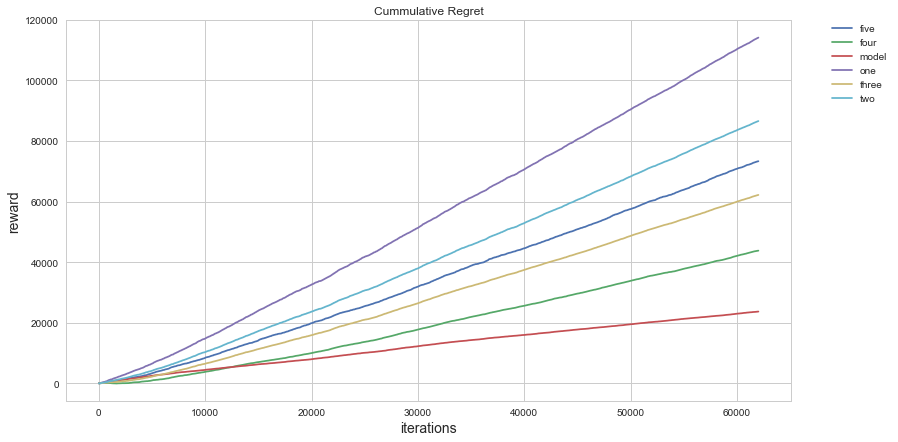

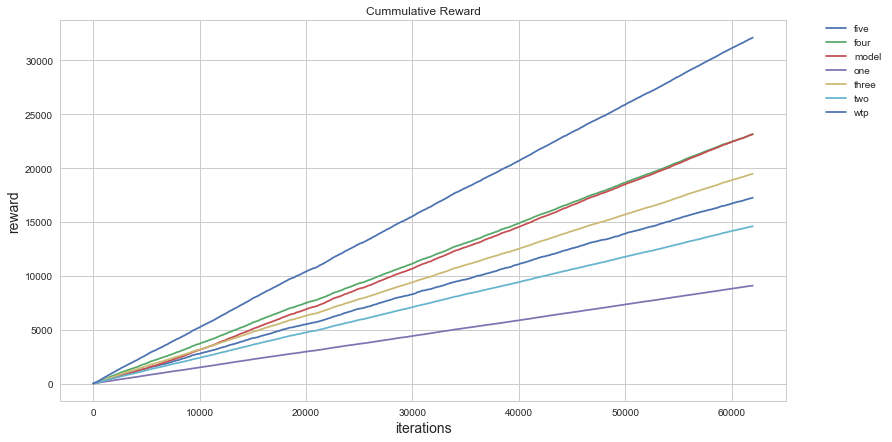

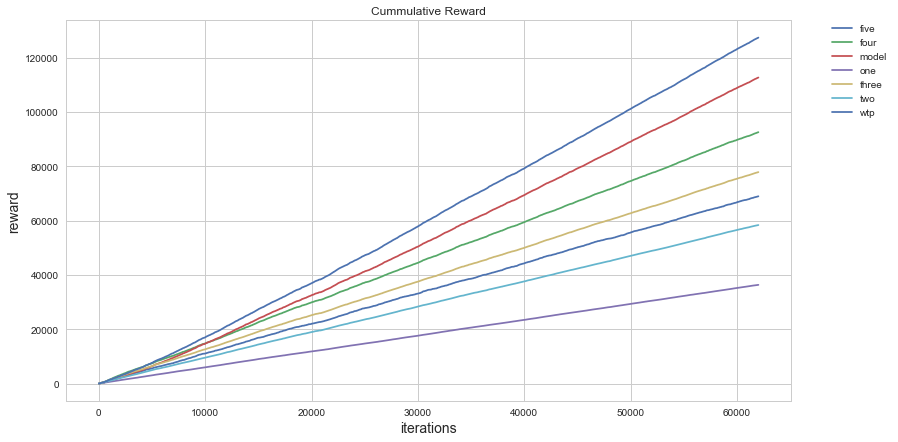

In [13]:
######PARAMETERS##########
print(params)
######PERFORMANCE##########
#total cummulative regret
plot_c_regret(c_reward)
plot_c_reward(c_reward, c_type, 'n')
plot_c_reward(c_reward, c_type, 'r')

/Users/daryazmachynskaya/gU/DL/PROJECT/final/sumplotter.py:56: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(span=500,min_periods=0,adjust=True,ignore_na=False).mean()
  loss = pd.ewma(loss, span=smooth)


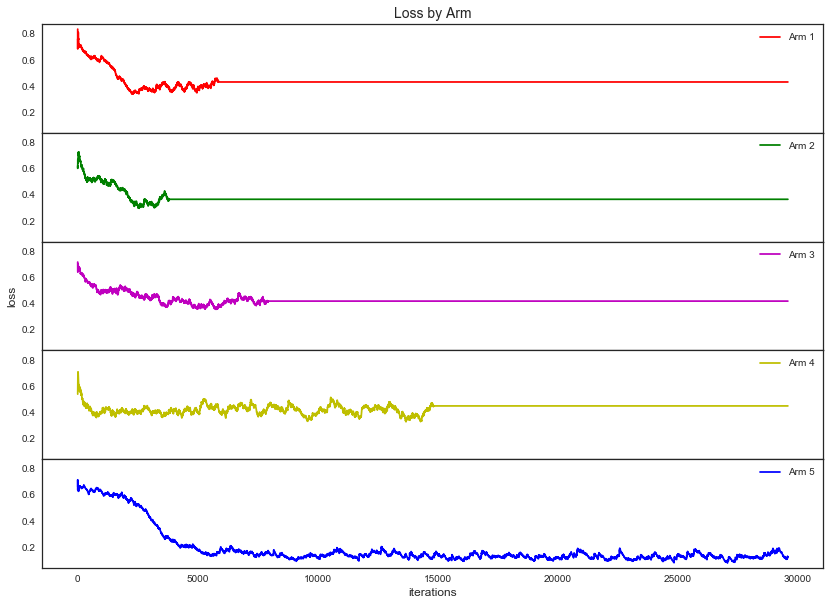

In [15]:
plot_arm_loss(losses, smooth=500)

## Appendix: Parameter Tuning
> The following cells contain outcomes of several parameters that I varied in an attempt to find a better model

{'lr': 0.0001, 'n_hidden_lstm': 16, 'n_cell_lstm': 2, 'out_lstm': 5, 'n_hidden_affine': 32, 'n_cell_affine': 2}


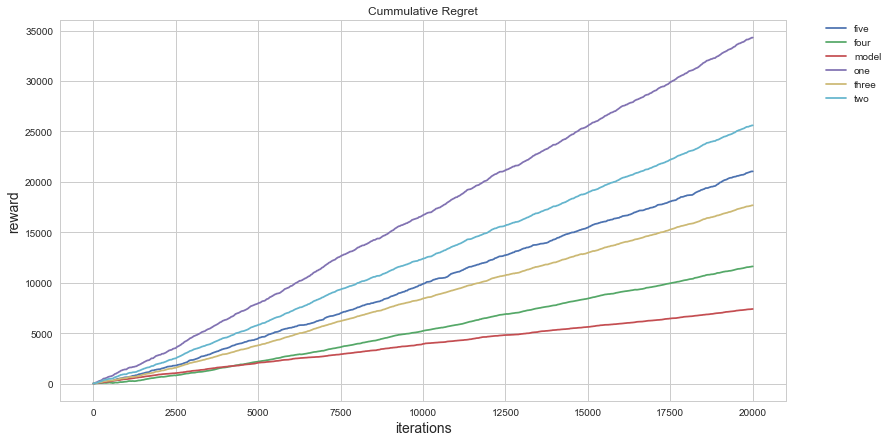

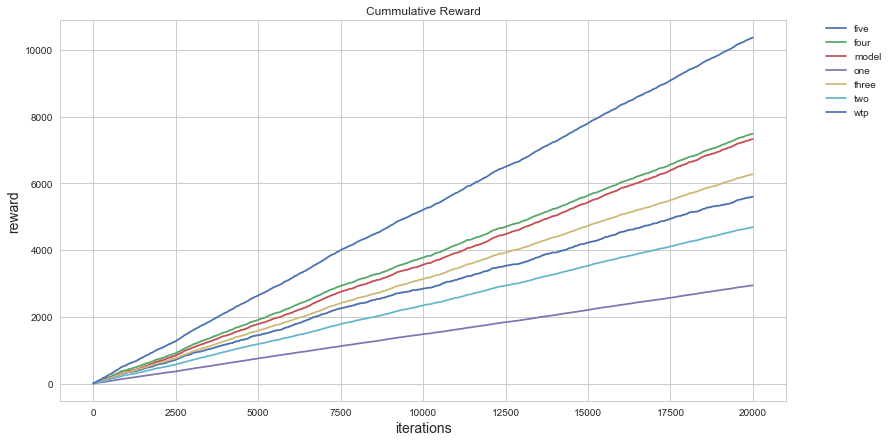

In [3]:
######PARAMETERS##########
print(params)
######PERFORMANCE##########
#total cummulative regret
plot_c_regret(c_reward)
plot_c_reward(c_reward, c_type, 'n')

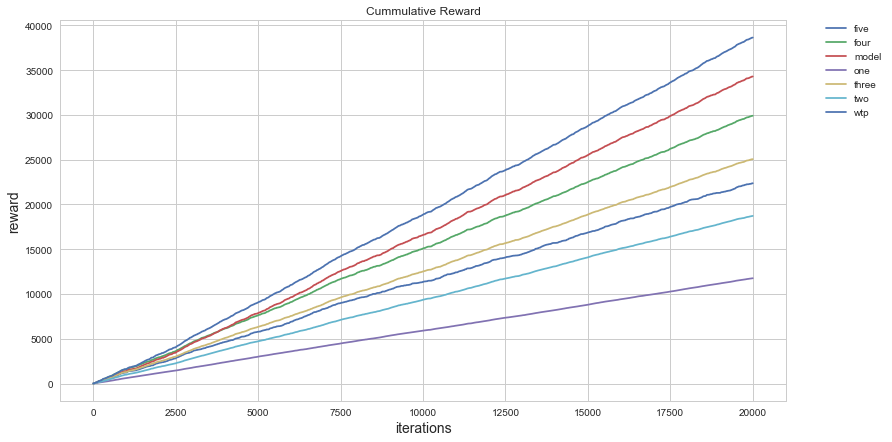

In [4]:
plot_c_reward(c_reward, c_type, 'r')

{'lr': 0.0001, 'n_hidden_lstm': 32, 'n_cell_lstm': 2, 'out_lstm': 5, 'n_hidden_affine': 32, 'n_cell_affine': 2}


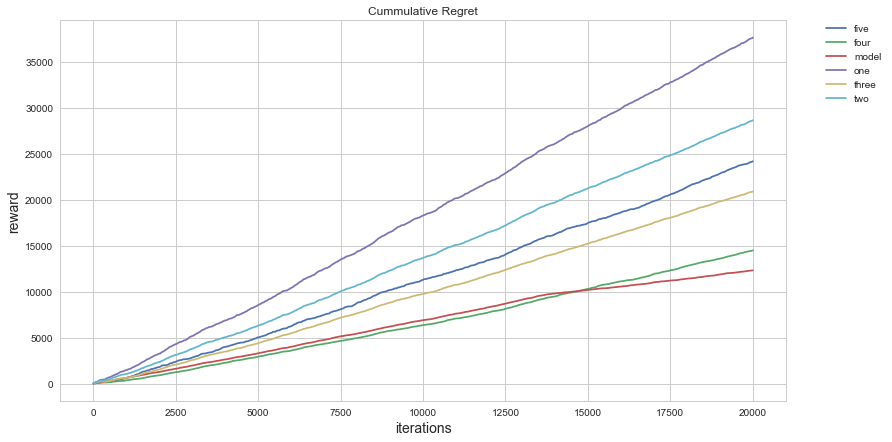

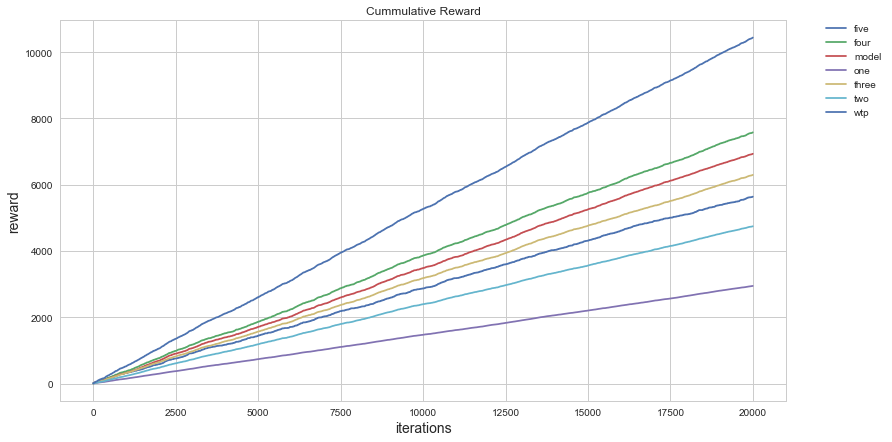

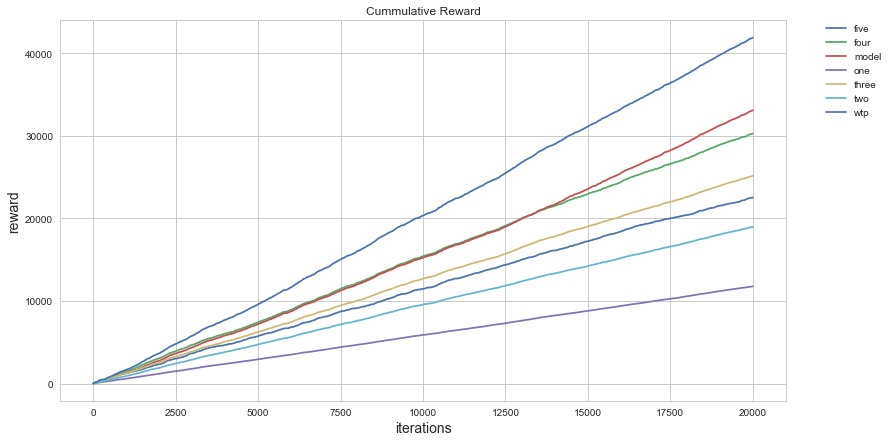

In [6]:
######PARAMETERS##########
print(params)
######PERFORMANCE##########
#total cummulative regret
plot_c_regret(c_reward)
plot_c_reward(c_reward, c_type, 'n')
plot_c_reward(c_reward, c_type, 'r')

{'lr': 0.0001, 'n_hidden_lstm': 16, 'n_cell_lstm': 2, 'out_lstm': 10, 'n_hidden_affine': 32, 'n_cell_affine': 2}


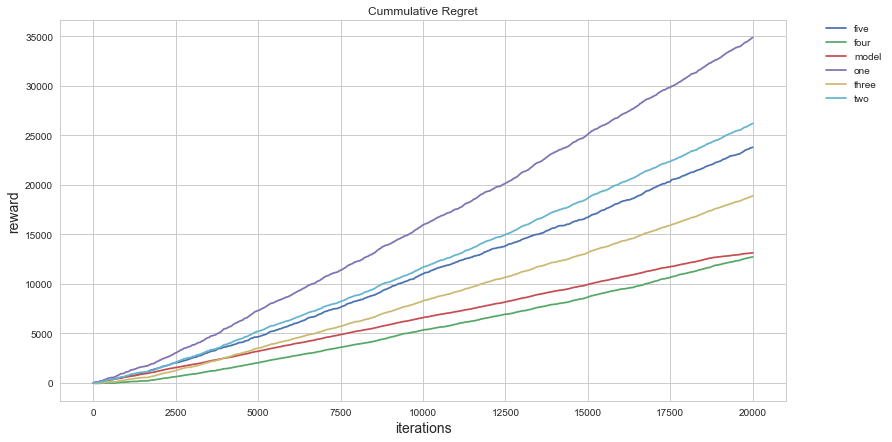

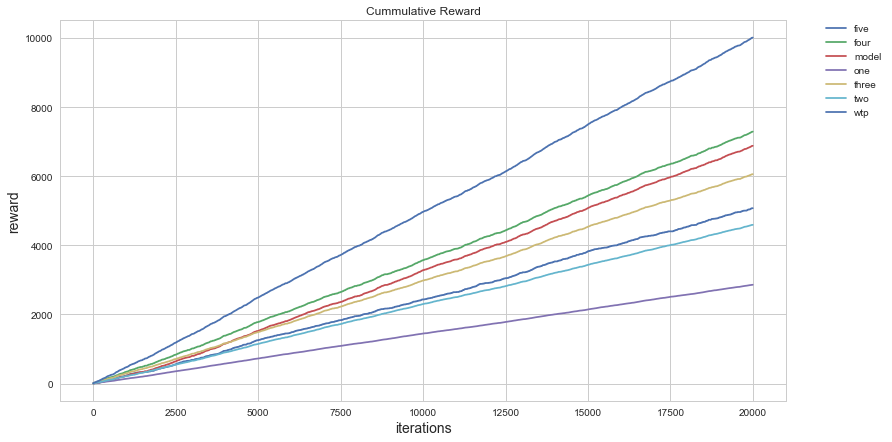

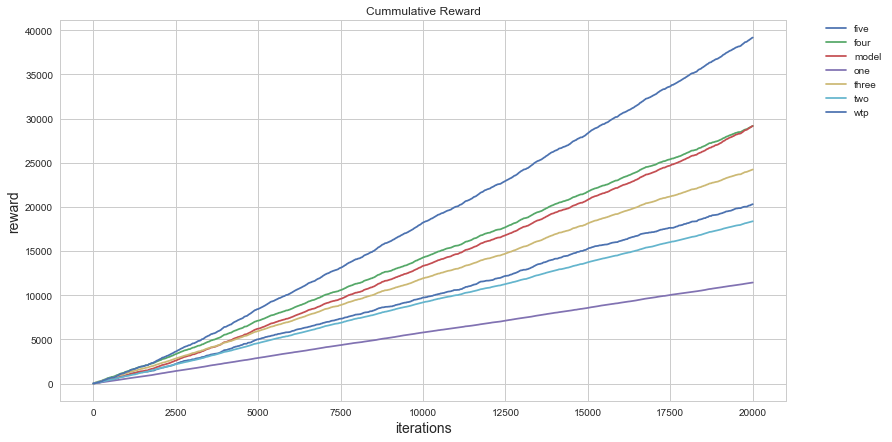

In [4]:
######PARAMETERS##########
print(params)
######PERFORMANCE##########
#total cummulative regret
plot_c_regret(c_reward)
plot_c_reward(c_reward, c_type, 'n')
plot_c_reward(c_reward, c_type, 'r')

{'lr': 0.0001, 'n_hidden_lstm': 16, 'n_cell_lstm': 2, 'out_lstm': 5, 'n_hidden_affine': 64, 'n_cell_affine': 2}


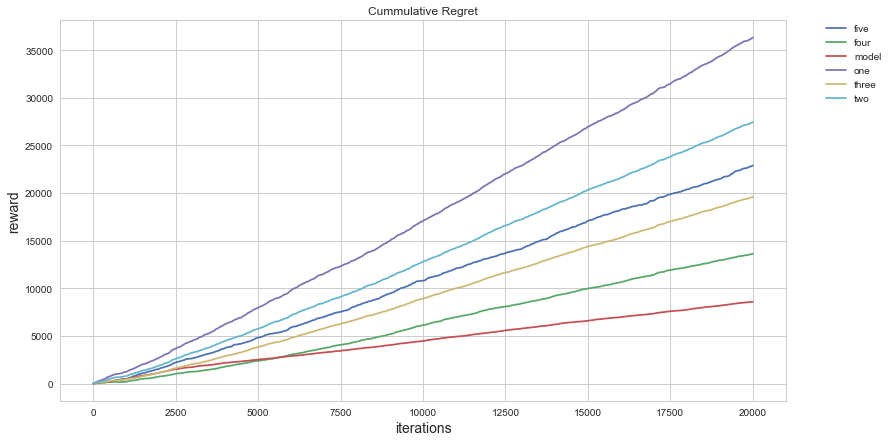

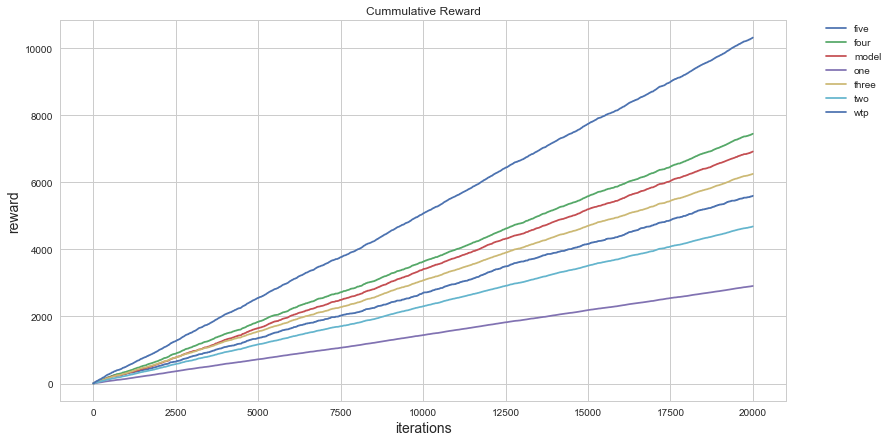

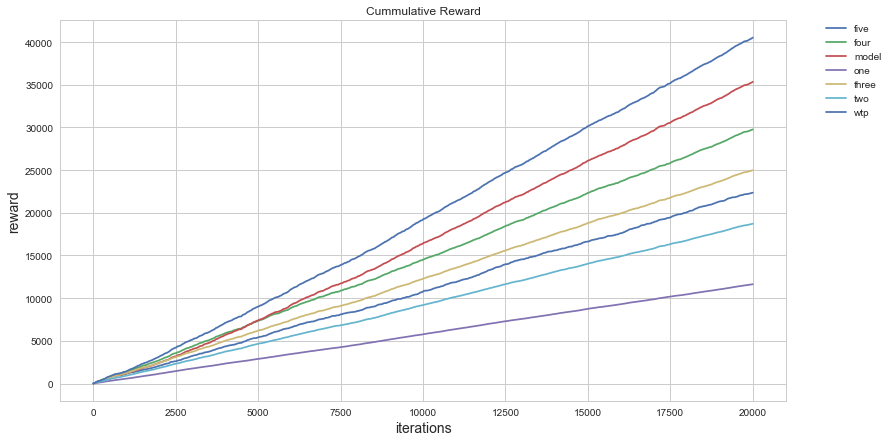

In [6]:
######PARAMETERS##########
print(params)
######PERFORMANCE##########
#total cummulative regret
plot_c_regret(c_reward)
plot_c_reward(c_reward, c_type, 'n')
plot_c_reward(c_reward, c_type, 'r')

{'lr': 0.0005, 'n_hidden_lstm': 16, 'n_cell_lstm': 2, 'out_lstm': 5, 'n_hidden_affine': 16, 'n_cell_affine': 3}


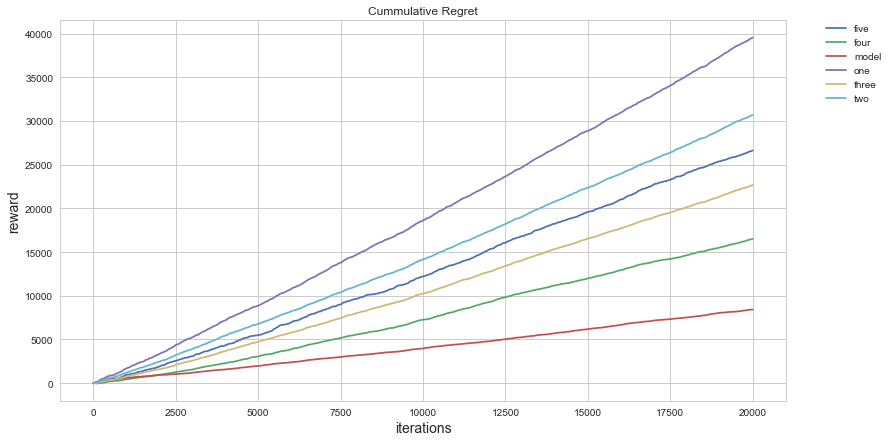

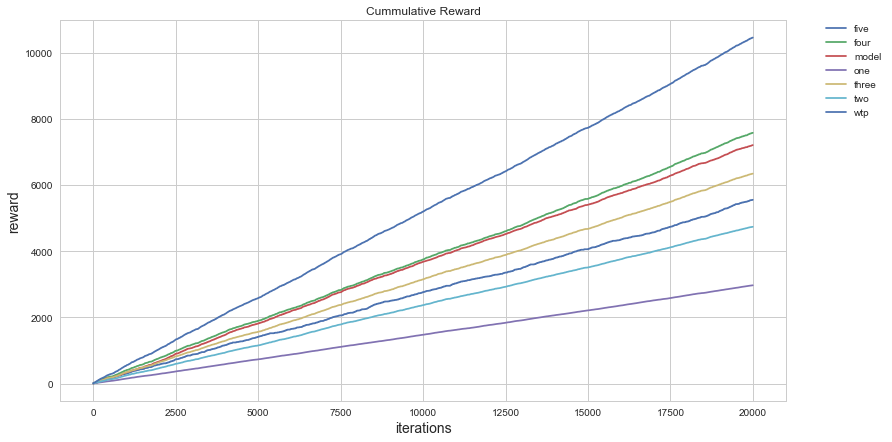

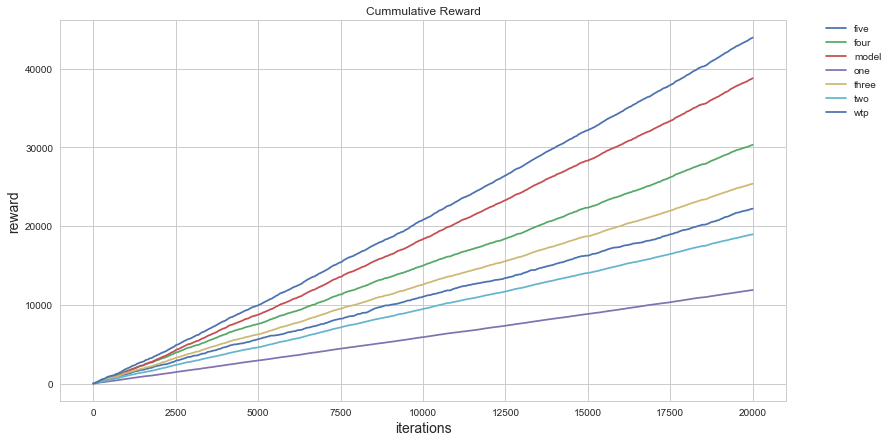

In [9]:
######PARAMETERS##########
print(params)
######PERFORMANCE##########
#total cummulative regret
plot_c_regret(c_reward)
plot_c_reward(c_reward, c_type, 'n')
plot_c_reward(c_reward, c_type, 'r')